# Convolutional neural networks (CNNs)

![GPI-CESI.jpg](attachment:GPI-CESI.jpg)

|Author|Center|Modification|
|---|---|---|
|Nassim HADDAM|Nanterre|2020/12/08|

The aim of this workshop is to introduce you to the basics of convolutional neural networks (CNNs). Convolutional neural networks (CNNs) are a special architecture for learning computer vision tasks. The application you are about to carry out consists in classifying images of flowers. The dataset is provided, and you will be guided through the workshop. You will be working mainly with [`keras`](https://keras.io/api/), an opensource library for deep learning that has been integrated into version 2 of [`tensorflow`](https://www.tensorflow.org/).

# 1 Loading data and building a dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

2025-09-29 21:35:37.079855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-29 21:35:38.426080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 21:35:42.728047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


We start by downloading the images we're going to use for image classification:

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

data_dir

PosixPath('/home/steve/.keras/datasets/flower_photos')

To begin with, we need to specify a few parameters for learning:
<ul>
    <li>The length and width of the images. </li>
    <li>The batch size.</li>
</ul>

In [3]:
image_h = 180
image_w = 180
batch_s = 32

Next, we need to divide the dataset into a training set and a test set. As a reminder, the training set will be used to train the neural network, while the test set will be used to measure the performance of your architecture on data it has never seen before. The training set is a fraction of the total dataset (in this case 80%). You will use the function [`tf.keras.preprocessing.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). This function is used to generate a dataset from image files in a directory.

**Note**: The learning algorithm must **never** see the test set or train on the examples it contains, as this would bias the results obtained.

In [4]:
# The train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset ='training', seed=42, image_size=(180, 180), batch_size=12)

# The test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', seed=42, image_size=(180, 180), batch_size=12)

Found 7340 files belonging to 6 classes.
Using 5872 files for training.


2025-09-29 21:35:49.070900: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 7340 files belonging to 6 classes.
Using 1468 files for validation.


The release states that we have 3670 files in total, 2936 of which belong to the training set and 734 to the test set. Now that the dataset is ready, we need to explore/visualize the data to get a better intuition of what's going on.

# 2. Data exploration and visualization
Let's start by displaying the class names. We know we're interested in flowers, but we don't even know which ones.

In [5]:
class_names = train_set.class_names #PLEASE COMPLETE
print(class_names)

['daisy', 'dandelion', 'flower_photos', 'roses', 'sunflowers', 'tulips']


The result is displayed. In French, it's `['marguerite', 'pissenlit', 'roses', 'tournesols', 'tulipes']`. Next, let's use [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html) to display a few images to see what these classes correspond to.

2025-09-29 21:35:49.636464: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


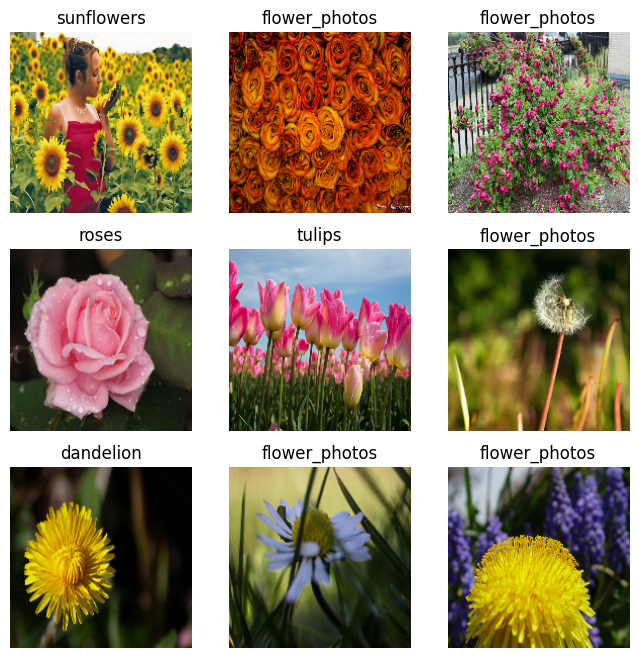

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Clearly, there are different types of flowers. On the face of it, there is only one type of flower per image (it would be complicated to classify otherwise).

However, there are a number of elements that can complicate image interpretation. An image may represent one or more flowers of the same type, the angle of the photo is not always the same, as is the luminosity, the distance from the lens to the flowers, etc. The background can also vary enormously. The background can also vary enormously from one image to another. Last but not least, there are sometimes other objects in the image, whether present in nature (bees) or not (bags). Fortunately, we have tools at our disposal to deal with this kind of problem, as we'll see below.

We'd also like to know the size of the data, which could be useful for managing model performance. In the cell below, the type of `train_set` is [`BatchDataset`](https://www.tensorflow.org/api_docs/python/tf/raw_ops/BatchDataset), an object containing image batches. We take an element from `train_set` and display the first batch. This is a tensor ($n$-dimensional matrix) of the form (32, 180, 180, 3). This tensor represents a batch of 32 images of dimensions 180x180x3 (the last dimension represents the RGB channels). The `label_batch` variable is a tensor of the form (32,), containing the labels of the images in the batch.

In [7]:
print(type(train_set))
images, labels = next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(12, 180, 180, 3)
(12,)


Now it's time to configure our environment and get down to business.

# 3. Setting up the training environment
In this section, you'll need to use the [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) functions to configure the data to improve performance as follows:
- Dataset.cache()`: This function is used to force data to be cached in memory. As the neural network makes several passes (called _epoch_) over the data during training, this function avoids having to reload the images each time.
- Dataset.prefetch()`: This function preprocesses the current element of the dataset (e.g. the next batch) at the same time as the model trains/evaluates the current batch. In a multi-processor or multi-core environment, this saves considerable time.

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Normalization
Generally speaking, in machine learning, you will often need to transform the value scale of attributes so that they take values that are in the same interval. This transformation will have the effect of making learning more uniform across the different attributes, and therefore of not overestimating the importance of one attribute compared to another (this can happen if, for example, the attributes have completely different scales). In this workshop you will apply [normalization](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17), which simply consists of dividing the input (the value of a pixel's RGB component) by 255 to transform the input into the interval [0, 1]. This is done using the function [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling).

# 5. The convolutional neural network (CNN) model
The CNN is a specialized neural network architecture created to efficiently learn computer vision tasks. An example of this architecture is shown below. The special feature of these neural networks is the introduction of convolutional layers in the hidden layers:
- You saw in the image processing workshop that convolution operations are used to extract various features and information contained in the image (we saw [contour] detection( https://fr.wikipedia.org/wiki/D%C3%A9tection_de_contours), but there is also [corner] detection( https://en.wikipedia.org/wiki/Corner_detection), and also [blob] detection( https://en.wikipedia.org/wiki/Blob_detection)).
- You also know from the previous workshop that in neural networks, neurons in the deeper layers build on neurons in the first layers to detect higher-level attributes of the input data. For images, for example, the low-level features are those mentioned in the previous point (contours, corners, blobs...), and the high-level features could be the presence of certain patterns, textures, shapes built up from the low-level attributes.
![convolutional_architecture.png](attachment:convolutional_architecture.png)
Convolutional neural networks combine the two previous ideas to form networks in which certain neurons are used to represent more or less local information on images through the application of the convolution operation. These neurons (from so-called convolutional layers) are connected only to neighboring neurons in the previous layer. The output of these same neurons is obtained by applying convolutional filters to the previous layer. These filters represent the weights of the convolutional layer and are used to describe image attributes learned from the dataset. An example of convolution at the convolution layer level is given below (and taken from this [link](https://cs231n.github.io/convolutional-networks/)). Can you tell us why it is more interesting to opt for a convolutional neural network architecture instead of keeping the classical architecture for computer vision tasks?
![gif_convolution.gif](attachment:gif_convolution.gif)

<em>PLEASE COMPLETE</em>

After these theoretical discussions on CNNs, let's move on to the code. To code your model, you first need to create an empty model using tensorflow's [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) function. The rest of this section will guide you through the implementation of a potential model for image classification, and will also introduce a few notions about convolutional neural networks.

In [9]:
num_classes = 5 # Number of classes and therefore also number of neurons in the last layer
model = Sequential()

Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes).

Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Vous utiliserez la couche [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) à cet effet.

In [10]:

model = models.Sequential([
    layers.Rescaling(
        1./255,         
        input_shape=(28, 28, 3)
    )
])


/home/steve/deep-learning-env/lib/python3.13/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


After that, you'll implement your first **convolutional block**. A convolutional block consists of two layers specific to convolutional neural networks: the [convolutional layer](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_convolution_(CONV)) (which was introduced briefly), and the [pooling layer](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_pooling_(POOL)). For more details on these layers at level, [this Notebook](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb) will be useful. Architectures handle these layers in potentially different ways, but it's common to use them as follows:

- The convolution layer: This is used to detect the presence of attributes at the image level using the convolution operation, and thus extract more and more features. The application of this layer is generally aimed at returning higher-level attributes to the image. The effect is to increase the depth of the image if the number of filters is large enough. In this workshop, you need to pad (https://ayeshmanthaperera.medium.com/what-is-padding-in-cnns-71b21fb0dd7) so that the size of the output remains the same as the input. There should be 16 filters of size `(3,3)` in this first layer. Don't forget that the output of this layer must be passed to an activation function (the ReLU function).

- The pooling layer: This is used to compress the output of the convolutional layer by taking the most salient information from it. The output of the convolutional layer is divided into square blocks of equal size. For each block, the maximum value is retained and the others are ignored, while the height and width of the layer are reduced.

Passing the output of a layer to a convolution block allows you, on the one hand, to detect higher-level attributes by combining those of the previous layer, and, on the other hand, to reduce the number of neurons so as to take the most active neurons needed for the task (thanks to the pooling layer). You should therefore add both layers, referring to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/). Note that you're asked to pool the maximum number of neurons and that the input consists of 2D images.

In [14]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,302 (57.86 MB)

 Trainable params: 15,167,302 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

Implement the rest of the network. This should contain the following elements:
- A convolutional block similar to the previous one, containing 32 filters of height and width 3.
- A convolutional block similar to the previous one, containing 64 filters of height and width 3.
- A layer containing the previous flattened layer.
- A fully connected layer of size 128.
- The final, fully connected (dense) layer returning the classification result.

There are a few remarks to be made about this architecture, and you can use the first CNN diagram to follow the remarks in this section:
- CNNs are generally made up of two parts, one made up of convolutional blocks, and one made up of dense layers. The first part serves, indirectly, to compress the image size for input to the second part, which will have far fewer neurons than the original number of pixels in the image.
- The layers of the convolutional block part gain in depth and lose in height and width as we move towards deeper layers in the network. We need this because the network needs to learn to recognize descriptive image attributes in order to perform classification. The number of attributes increases as we move deeper into the network, meaning that neurons in the deeper layers lose spatial information but gain descriptive information about the image.
What is the benefit in terms of memory and computation time of using convolutional neural network architectures? (Take an interest in the number of parameters).
<em>TO COMPLETE</em>

Finally, you need to specify the evolution of the training error and compare it with the test error. Note that training requires the training set, the test set and the number of epochs.

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 320s 648ms/step - accuracy: 0.4704 - loss: 1.4017 - val_accuracy: 0.4802 - val_loss: 1.2767
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 288s 587ms/step - accuracy: 0.4673 - loss: 1.2211 - val_accuracy: 0.4741 - val_loss: 1.2419
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 287s 516ms/step - accuracy: 0.4651 - loss: 1.1258 - val_accuracy: 0.4155 - val_loss: 1.2880
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 254s 519ms/step - accuracy: 0.4625 - loss: 1.0293 - val_accuracy: 0.3563 - val_loss: 1.3382
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 264s 523ms/step - accuracy: 0.4642 - loss: 0.9433 - val_accuracy: 0.3420 - val_loss: 1.4337
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 253s 516ms/step - accuracy: 0.4687 - loss: 0.8871 - val_accuracy: 0.2350 - val_loss: 1.4986
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 263s 519ms/step - accuracy: 0.4724 - loss: 0.8382 - val_accuracy: 0.1873 - val_loss: 1.6372
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 261s 518ms/step - accuracy: 0.4860 -

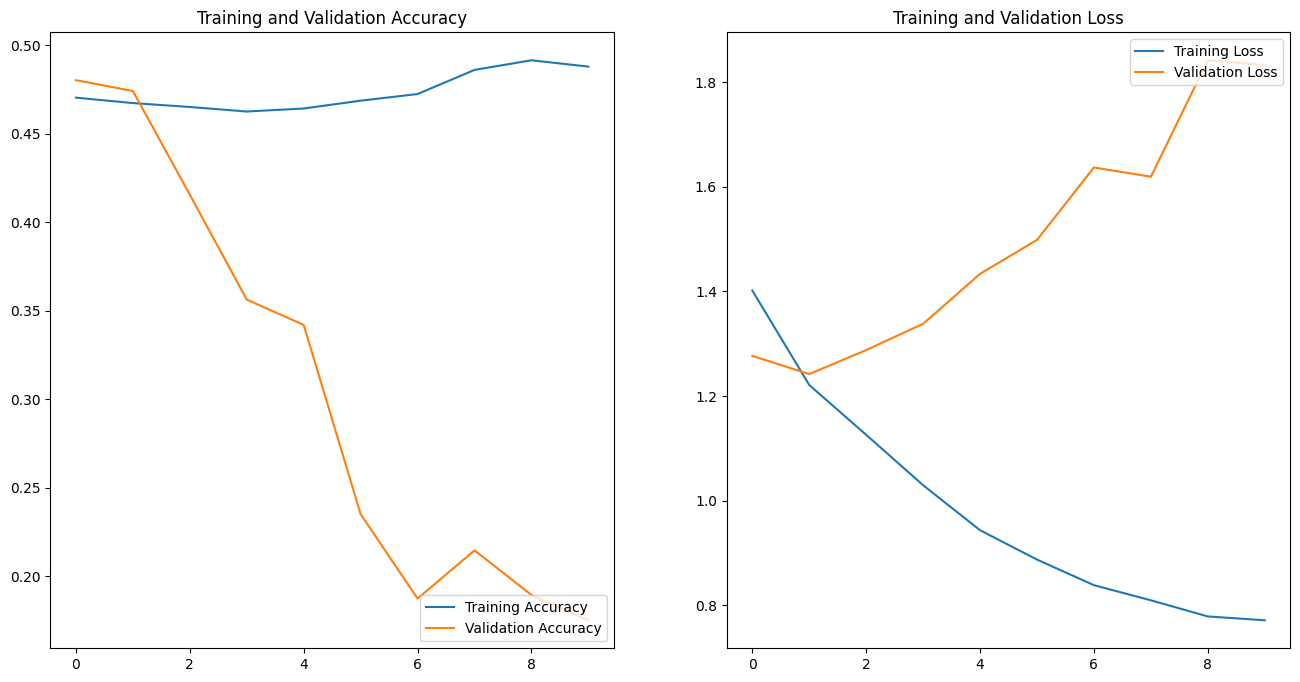

In [15]:
epochs=10
history =  model.fit(train_set, validation_data=test_set, epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The code in the previous cell is used to train the model and track the evolution of accuracy and loss over the training and test datasets. What do you see in these curves? Do you see any signs of over-training or under-training? Why or why not?
<em>PLEASE COMPLETE</em>

0n notice that the evolution of the curves is quite smooth, what would you do if the curves were very noisy?

<em>PLEASE COMPLETE</em>

So we're going to have to improve the performance of our learning algorithm, and in particular deal with this learning problem. Let's see how we might go about it.

# 6. Regularization techniques
Regularization techniques are designed to reduce overlearning. The aim is to prevent the neural network from memorizing the data set by foolishly adjusting itself to the particularities of the training set. The overall aim is to reduce the neural network's degrees of freedom. In this wokrshop, we'll look at two regularization techniques:
- Data augmentation**: Having more data is always good for reducing overlearning, hence data augmentation. The principle is to add new images by performing transformations on the original training set. These new images are obtained by affine transformations, or generally by realistic transformations that do not change the nature of the label assigned to the image. This technique is very effective, as neural networks are very data-intensive.
- The dropout technique**: This technique consists of randomly deactivating the neurons of a dense layer of the network at each processing step. The dropout depends on a parameter representing the probability of deactivation of the layer's neurons. This probability is the average proportion of active neurons in the layer during training iterations. It is used to reduce the complexity of the neural network in order to reduce overlearning.

These techniques are used to reduce overlearning in neural networks. But can you say why data augmentation is useful when the data generated comes from the training dataset? Would there really be more information contained in our dataset than is already there? Try taking an example image and thinking about what might happen if we applied a rotation to it.

<em>PLEASE COMPLETE</em>
Can you detail how dropout is useful for managing overlearning problems? What are the advantages of dopout? You have to think in terms of the size of the model and its ability to memorize/learn details specific to the dataset.
<em>PLEASE COMPLETE</em>

In the cells that follow, you'll re-implement the model and redo the training by including a dropout layer (preceding the flattening layer), all the while adding a data augmentation layer. First implement the previous network, adding only the dropout.

In [18]:
from tensorflow.keras import layers, models

# Build the model with Dropout
model_with_dropout = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(6, activation='softmax')
])

# Compile the model
model_with_dropout.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_with_dropout.summary()


epochs = 10
history = model_with_dropout.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    15,147,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,167,302 (57.86 MB)

 Trainable params: 15,167,302 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 260s 527ms/step - accuracy: 0.4785 - loss: 1.5526 - val_accuracy: 0.5123 - val_loss: 1.2941
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 251s 512ms/step - accuracy: 0.4821 - loss: 1.3348 - val_accuracy: 0.5170 - val_loss: 1.2998
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 250s 509ms/step - accuracy: 0.4862 - loss: 1.2836 - val_accuracy: 0.5027 - val_loss: 1.2391
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 250s 510ms/step - accuracy: 0.4848 - loss: 1.2055 - val_accuracy: 0.4925 - val_loss: 1.2133
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 262s 510ms/step - accuracy: 0.4821 - loss: 1.1443 - val_accuracy: 0.4871 - val_loss: 1.2063
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 262s 511ms/step - accuracy: 0.4911 - loss: 1.0966 - val_accuracy: 0.4789 - val_loss: 1.2082
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 250s 511ms/step - accuracy: 0.4911 - loss: 1.0489 - val_accuracy: 0.4680 - val_loss: 1.2947
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 250s 511ms/step - accuracy: 0.4823 -

What do you observe in terms of loss and precision?
<em>TO COMPLETE</em>

Let's move on to data augmentation. The corresponding layer is provided below. This layer traverses the training dataset and applies transformations to some randomly chosen images to augment the dataset. We can imagine several types of modification, in this case the transformations we'll apply to each image according to a certain probability are a horizontal inversion of the image followed by an 18-degree rotation to finish with a 10% vertical zoom. Complete and execute.

In [ ]:
image_h, image_w = 180, 180

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(image_h, image_w, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

Then add the increased data to your CNN and check the curves obtained after training and model evaluation.

In [ ]:
image_h, image_w = 180, 180
epochs = 10

complete_model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer (5 classes)
    layers.Dense(6, activation='softmax')
])

# Compile the model
complete_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
complete_model.summary()

# Train the model
history = complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

This time, we see a clear improvement in performance, with accuracy in the test set approaching that of the training set, and loss in the test set dropping almost continuously during training. That's good news. What else do you notice?
<em>PLEASE COMPLETE</em>

# 7. Conclusion

Congratulations, you have completed your first CNN! You've seen how to implement, train and evaluate a CNN, and how to improve its performance through regularization. Congratulations!

But you still have a lot to learn. First of all, the accuracy you get is only 73% (it can be very close to 100% for datasets like MNIST). This is not surprising given the size of your network, which is very small (the number of parameters in Google's RNs, for example, can reach a million or even a billion).

Obviously, increasing the size of the network will have a significant impact on learning speed. In this case, the use of high-performance GPUs can drastically improve performance, as they are very efficient for executing vision tasks. TensorFlow does this by default, but it is sometimes necessary to adapt its operation, such as selecting the right GPU (especially if you have a CPU with an integrated GPU, which is generally not very powerful, and a more powerful external GPU). You should easily be able to find [resources on the subject](https://stackoverflow.com/questions/53065420/by-default-does-tensorflow-use-gpu-cpu-simultaneously-for-computing-or-gpu-only).

There may be other ways to improve results. There are more advanced arhitectures of CNNs, such as ResNet, which connects deep layers with shallower layers.

Besides, we've only dealt with one computer vision task here: classification. But this is the simplest, and is rarely useful on its own in an application context (such as for autonomous cars, for example). There are many other computer vision tasks, each more difficult than the last, such as object detection (putting boxes and labels around objects), image segmentation (classifying each pixel), facial recognition, image restoration and so on.